In [217]:
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# from __future__ import division

In [218]:
import warnings
warnings.filterwarnings("ignore")

In [219]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [220]:
import os
df = pd.read_excel(
     os.path.join("Exc.xlsx"), engine='openpyxl')
df = df.rename(columns={"Umsatz":"sales", "Time":"date"})
df_sales = df

In [221]:
df_sales.head(10)

,date,sales
0,2007-09-30,5
1,2007-12-31,118
2,2008-03-31,241
3,2008-06-30,378
4,2008-09-30,419
5,2008-12-31,806
6,2009-03-31,2940
7,2009-06-30,2427
8,2009-09-30,3060
9,2009-12-31,4606


In [222]:
#create a new dataframe to model the difference
df_diff = df_sales.copy()

In [223]:
#add previous sales to the next row
df_diff['prev_sales'] = df_diff['sales'].shift(1)

In [224]:
df_diff.head()

,date,sales,prev_sales
0,2007-09-30,5,NaN
1,2007-12-31,118,5.0
2,2008-03-31,241,118.0
3,2008-06-30,378,241.0
4,2008-09-30,419,378.0


In [225]:
#drop the null values and calculate the difference
df_diff = df_diff.dropna()

In [226]:
df_diff['diff'] = (df_diff['sales'] - df_diff['prev_sales'])

In [227]:
df_diff.head(10)

,date,sales,prev_sales,diff
1,2007-12-31,118,5.0,113.0
2,2008-03-31,241,118.0,123.0
3,2008-06-30,378,241.0,137.0
4,2008-09-30,419,378.0,41.0
5,2008-12-31,806,419.0,387.0
6,2009-03-31,2940,806.0,2134.0
7,2009-06-30,2427,2940.0,-513.0
8,2009-09-30,3060,2427.0,633.0
9,2009-12-31,4606,3060.0,1546.0
10,2010-03-31,5578,4606.0,972.0


In [228]:
#create new dataframe from transformation from time series to supervised
df_supervised = df_diff.drop(['prev_sales'],axis=1)

In [229]:
#adding lags
for inc in range(1,13):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)

In [230]:
df_supervised.head(10)

,date,sales,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
1,2007-12-31,118,113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2008-03-31,241,123.0,113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2008-06-30,378,137.0,123.0,113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2008-09-30,419,41.0,137.0,123.0,113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2008-12-31,806,387.0,41.0,137.0,123.0,113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2009-03-31,2940,2134.0,387.0,41.0,137.0,123.0,113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2009-06-30,2427,-513.0,2134.0,387.0,41.0,137.0,123.0,113.0,NaN,NaN,NaN,NaN,NaN,NaN
8,2009-09-30,3060,633.0,-513.0,2134.0,387.0,41.0,137.0,123.0,113.0,NaN,NaN,NaN,NaN,NaN
9,2009-12-31,4606,1546.0,633.0,-513.0,2134.0,387.0,41.0,137.0,123.0,113.0,NaN,NaN,NaN,NaN
10,2010-03-31,5578,972.0,1546.0,633.0,-513.0,2134.0,387.0,41.0,137.0,123.0,113.0,NaN,NaN,NaN


In [231]:
df_supervised.tail(6)

,date,sales,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
49,2019-12-31,33362,7376.0,-5065.0,-20931.0,15227.0,7285.0,-8089.0,-23545.0,32258.0,4000.0,-8403.0,-21129.0,26218.0,4112.0
50,2020-03-31,55957,22595.0,7376.0,-5065.0,-20931.0,15227.0,7285.0,-8089.0,-23545.0,32258.0,4000.0,-8403.0,-21129.0,26218.0
51,2020-06-30,28962,-26995.0,22595.0,7376.0,-5065.0,-20931.0,15227.0,7285.0,-8089.0,-23545.0,32258.0,4000.0,-8403.0,-21129.0
52,2020-09-30,26418,-2544.0,-26995.0,22595.0,7376.0,-5065.0,-20931.0,15227.0,7285.0,-8089.0,-23545.0,32258.0,4000.0,-8403.0
53,2020-12-31,26444,26.0,-2544.0,-26995.0,22595.0,7376.0,-5065.0,-20931.0,15227.0,7285.0,-8089.0,-23545.0,32258.0,4000.0
54,2021-03-31,65597,39153.0,26.0,-2544.0,-26995.0,22595.0,7376.0,-5065.0,-20931.0,15227.0,7285.0,-8089.0,-23545.0,32258.0


In [232]:
#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)

In [233]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf 

# Define the regression formula
model = smf.ols(formula='diff ~ lag_1', data=df_supervised)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.025922615259785675


In [234]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf 

# Define the regression formula
model = smf.ols(formula='diff ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5', data=df_supervised)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.8563714096465624


In [235]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf 

# Define the regression formula
model = smf.ols(formula='diff ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5 + lag_6 + lag_7 + lag_8 + lag_9 + lag_10 + lag_11 + lag_12', data=df_supervised)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.8679338967577616


In [236]:
#import MinMaxScaler and create a new dataframe for LSTM model
from sklearn.preprocessing import MinMaxScaler
df_model = df_supervised.drop(['sales','date'],axis=1)

In [237]:
#split train and test set
train_set, test_set = df_model[0:-11].values, df_model[-11:].values

In [238]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   diff    42 non-null     float64
 1   lag_1   42 non-null     float64
 2   lag_2   42 non-null     float64
 3   lag_3   42 non-null     float64
 4   lag_4   42 non-null     float64
 5   lag_5   42 non-null     float64
 6   lag_6   42 non-null     float64
 7   lag_7   42 non-null     float64
 8   lag_8   42 non-null     float64
 9   lag_9   42 non-null     float64
 10  lag_10  42 non-null     float64
 11  lag_11  42 non-null     float64
 12  lag_12  42 non-null     float64
dtypes: float64(13)
memory usage: 4.4 KB


In [239]:
#apply Min Max Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)
# reshape training set
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)

# reshape test set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

In [240]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

In [241]:
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [258]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, nb_epoch=200, batch_size=1, verbose=1, shuffle=False)

Epoch 1/200
31/31 [==============================] - 1s 28ms/step - loss: 0.2048
Epoch 2/200
31/31 [==============================] - 0s 3ms/step - loss: 0.1935
Epoch 3/200
31/31 [==============================] - 0s 2ms/step - loss: 0.1823
Epoch 4/200
31/31 [==============================] - 0s 2ms/step - loss: 0.1713
Epoch 5/200
31/31 [==============================] - 0s 2ms/step - loss: 0.1601
Epoch 6/200
31/31 [==============================] - 0s 3ms/step - loss: 0.1487
Epoch 7/200
31/31 [==============================] - 0s 3ms/step - loss: 0.1371
Epoch 8/200
31/31 [==============================] - 0s 3ms/step - loss: 0.1254
Epoch 9/200
31/31 [==============================] - 0s 3ms/step - loss: 0.1138
Epoch 10/200
31/31 [==============================] - 0s 3ms/step - loss: 0.1023
Epoch 11/200
31/31 [==============================] - 0s 2ms/step - loss: 0.0911
Epoch 12/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0804
Epoch 13/200
31/31 [================

31/31 [==============================] - 0s 4ms/step - loss: 0.0091
Epoch 102/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 103/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 104/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0090
Epoch 105/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 106/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0089
Epoch 107/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 108/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 109/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 110/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0087
Epoch 111/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0087
Epoch 112/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0086
Epoch 113/200
31/31 [=========

31/31 [==============================] - 0s 3ms/step - loss: 0.0054


In [259]:
y_pred = model.predict(X_test,batch_size=1)

In [260]:
y_pred

array([[-0.52000344],
       [-0.02595981],
       [ 0.7826078 ],
       [-1.1577138 ],
       [-0.49608383],
       [ 0.05543419],
       [ 0.9473265 ],
       [-0.97877455],
       [-0.36720505],
       [ 0.19090419],
       [ 1.077504  ]], dtype=float32)

In [261]:
y_test

array([[-0.44605129],
       [ 0.10495851],
       [ 0.38960271],
       [-0.90631328],
       [-0.33767002],
       [ 0.10821999],
       [ 0.65367453],
       [-1.12364927],
       [-0.24731645],
       [-0.15520671],
       [ 1.24711933]])

In [262]:
#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])

In [263]:
#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    np.concatenate([y_pred[index],X_test[index]],axis=1)
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))

In [264]:
pred_test_set[0]

array([[-0.52000344, -1.09050893,  1.19550511,  0.03341353, -0.47665166,
        -1.10159457,  0.94442764, -0.01084655, -0.56920617, -1.41026976,
         0.57931465, -0.38855328, -0.89657327]])

In [265]:
#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])

In [266]:
#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

In [267]:
#create dataframe that shows the predicted sales
result_list = []
sales_dates = list(df_sales[-12:].date)
act_sales = list(df_sales[-12:].sales)
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['date'] = sales_dates[index+1]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)

In [268]:
df_result

,pred_value,date
0,27406,2018-09-30
1,33102,2018-12-31
2,62947,2019-03-31
3,24036,2019-06-30
4,21566,2019-09-30
5,31889,2019-12-31
6,64150,2020-03-31
7,33004,2020-06-30
8,23072,2020-09-30
9,36101,2020-12-31


In [269]:
df_sales.head()

,date,sales
0,2007-09-30,5
1,2007-12-31,118
2,2008-03-31,241
3,2008-06-30,378
4,2008-09-30,419


In [270]:
#merge with actual sales dataframe
df_sales_pred = pd.merge(df_sales,df_result,on='date',how='left')

In [271]:
df_sales_pred

,date,sales,pred_value
0,2007-09-30,5,NaN
1,2007-12-31,118,NaN
2,2008-03-31,241,NaN
3,2008-06-30,378,NaN
4,2008-09-30,419,NaN
5,2008-12-31,806,NaN
6,2009-03-31,2940,NaN
7,2009-06-30,2427,NaN
8,2009-09-30,3060,NaN
9,2009-12-31,4606,NaN


Text(0.5, 0, 'Zeit')

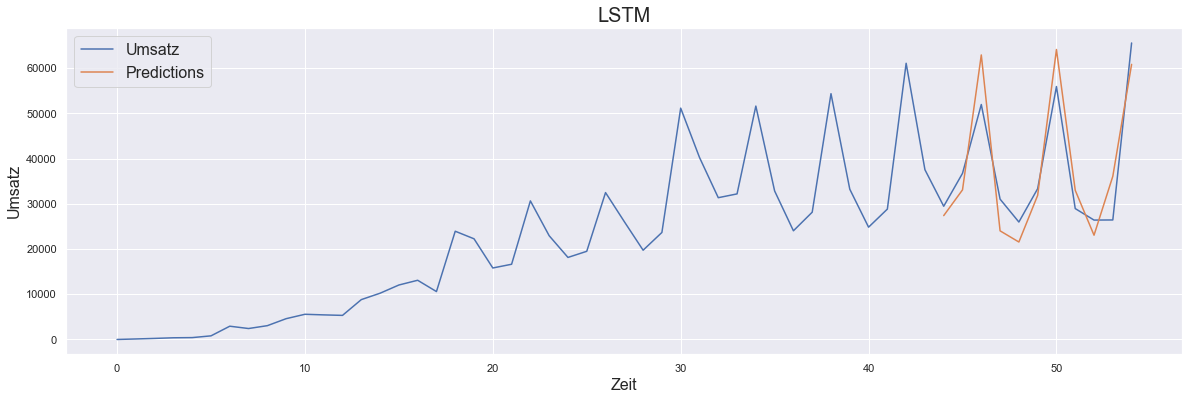

In [272]:
import seaborn as sns
sns.set()
plt.figure(figsize=(20,6))
plt.plot(df_sales_pred.sales)
plt.plot(df_sales_pred.pred_value)
plt.legend(('Umsatz', 'Predictions'), fontsize=16)
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.15)
plt.title('LSTM', fontsize=20)
plt.ylabel('Umsatz', fontsize=16)
plt.xlabel("Zeit", fontsize=16)

In [273]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error as mae, mean_squared_error
a = df_sales_pred.sales[-11:]
b = df_sales_pred.pred_value[-11:]
print(
     "MAPE:", mean_absolute_percentage_error(a, b),
      "MAE:", mae(a, b),
      "RMSE:", np.sqrt(mean_squared_error(a, b)))

MAPE: 0.15186359852444473 MAE: 5414.636363636364 RMSE: 6172.296986609531
